# **Building ANN using PyTorch**

## **Import Dependencies**

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchmetrics.classification import MulticlassAccuracy

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = 'Times New Roman'

# Set random seeds for reproducibility
torch.manual_seed(42)

# Setup device agnostic code to run the model on GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Current device: {device}')

Current device: cuda


## **Read the Dataset**

In [119]:
# Load the Fashion MNIST dataset using Pandas
train_data = pd.read_csv(r'D:\GITHUB\pytorch-for-deep-learning-and-machine-learning\datasets\fashion-mnist_train.csv')
test_data = pd.read_csv(r'D:\GITHUB\pytorch-for-deep-learning-and-machine-learning\datasets\fashion-mnist_test.csv')

print(train_data.shape, test_data.shape)
train_data.head()

(60000, 785) (10000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## **Data Pre-processing**

### **Split the Data into Input and Target**

In [120]:
# Split the data into target and labels
X_train, y_train = train_data.drop(columns=['label']), train_data['label']
X_test, y_test = test_data.drop(columns=['label']), test_data['label']

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.head()

(60000, 784) (10000, 784) (60000,) (10000,)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,1,2,0,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


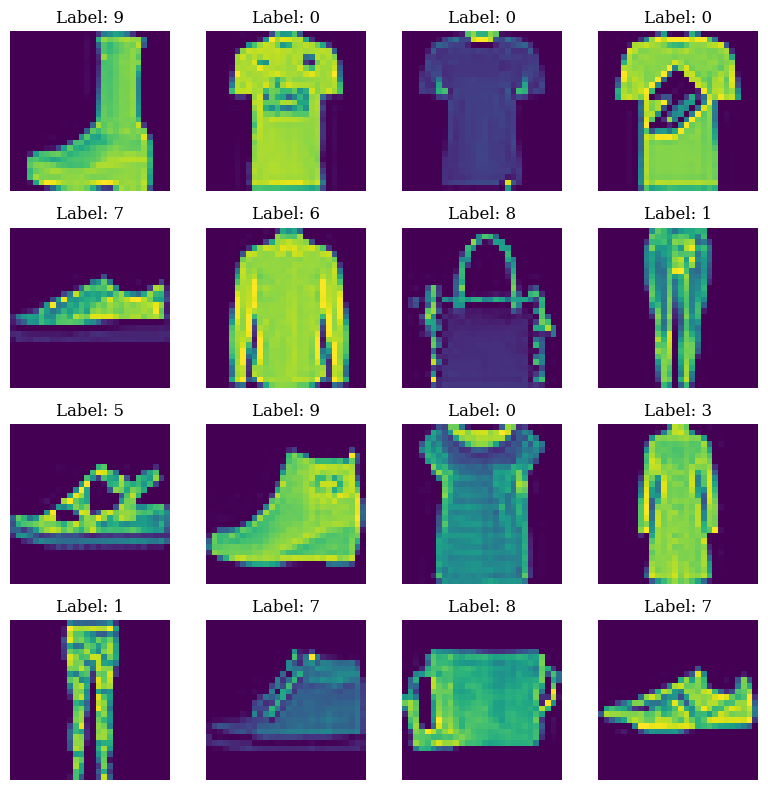

In [121]:
# Create a 4x4 grid of random images from training data
random_ids = [random.randint(0, X_train.shape[0]) for i in range(16)]

fig, axes = plt.subplots(ncols=4, nrows=4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    img = X_train.iloc[random_ids[i]].values.reshape(28, 28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Label: {y_train[random_ids[i]]}')

plt.tight_layout()
plt.show()

### **Scale the Data**

In [122]:
X_train = X_train / 255.0
X_test = X_test / 255.0

print(X_train.shape, X_test.shape)

(60000, 784) (10000, 784)


### **Convert NumPy Arrays to PyTorch Tensors**

In [123]:
X_train = torch.from_numpy(X_train.values).type(torch.float32)
X_test = torch.from_numpy(X_test.values).type(torch.float32)
y_train =  torch.from_numpy(y_train.values).type(torch.long)
y_test =  torch.from_numpy(y_test.values).type(torch.long)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([60000, 784]) torch.Size([10000, 784]) torch.Size([60000]) torch.Size([10000])


## **Create Dataset and DataLoader**

In [124]:
# Create a Fashion MNIST dataset class
class FashionMNISTDataset(Dataset):

    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

# Create the training and testing dataset
train_dataset = FashionMNISTDataset(X_train, y_train)
test_dataset = FashionMNISTDataset(X_test, y_test)

In [125]:
# Create dataloader object
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=True)

## **Build an Artificial Neural Network (ANN) Model**

In [126]:
# Create an ANN class with two hidden layers
class MyANNModel(nn.Module):

    def __init__(self, n_features):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=n_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10),
        )

    def forward(self, X: torch.Tensor):
        out = self.network(X)
        return out

### **Training Pipeline**

In [127]:
# Create an object of the model
model = MyANNModel(X_train.shape[1]).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
MyANNModel                               --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       100,480
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       8,256
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       650
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0

In [128]:
# Define the learning rate and the number of epochs
lr = 0.1
epochs = 50

# Define the optimizer and the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [129]:
# Define a loop 
for epoch in range(epochs):

    ## Training
    model.train()

    total_train_loss = 0

    for batch_X, batch_y in train_dataloader:

        # Move data to gpu
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Forward pass
        y_pred = model(batch_X)

        # Loss calculation
        loss = loss_fn(y_pred, batch_y)
        total_train_loss += loss

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Parameters update
        optimizer.step()

    ## Testing
    model.eval()

    total_test_loss = 0

    for batch_X, batch_y in test_dataloader:

        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        with torch.no_grad():
            test_pred = model(batch_X)
            loss = loss_fn(test_pred, batch_y)
            total_test_loss += loss

    # Print the epoch training and testing loss
    print(f'Epoch: {epoch+1}, Train Loss: {(total_train_loss / len(train_dataloader)):.4f}, Test Loss: {(total_test_loss / len(test_dataloader)):.2f}')

Epoch: 1, Train Loss: 0.6011, Test Loss: 0.42
Epoch: 2, Train Loss: 0.4141, Test Loss: 0.41
Epoch: 3, Train Loss: 0.3695, Test Loss: 0.38
Epoch: 4, Train Loss: 0.3422, Test Loss: 0.34
Epoch: 5, Train Loss: 0.3231, Test Loss: 0.33
Epoch: 6, Train Loss: 0.3087, Test Loss: 0.34
Epoch: 7, Train Loss: 0.2952, Test Loss: 0.33
Epoch: 8, Train Loss: 0.2843, Test Loss: 0.33
Epoch: 9, Train Loss: 0.2745, Test Loss: 0.32
Epoch: 10, Train Loss: 0.2641, Test Loss: 0.32
Epoch: 11, Train Loss: 0.2575, Test Loss: 0.33
Epoch: 12, Train Loss: 0.2509, Test Loss: 0.32
Epoch: 13, Train Loss: 0.2435, Test Loss: 0.29
Epoch: 14, Train Loss: 0.2374, Test Loss: 0.32
Epoch: 15, Train Loss: 0.2318, Test Loss: 0.31
Epoch: 16, Train Loss: 0.2249, Test Loss: 0.32
Epoch: 17, Train Loss: 0.2201, Test Loss: 0.34
Epoch: 18, Train Loss: 0.2165, Test Loss: 0.34
Epoch: 19, Train Loss: 0.2092, Test Loss: 0.33
Epoch: 20, Train Loss: 0.2043, Test Loss: 0.31
Epoch: 21, Train Loss: 0.2011, Test Loss: 0.31
Epoch: 22, Train Loss:

## **Model Evaluation**

In [158]:
# Model evaluation using test dataloader
model.eval()

# Initialize the accuracy metric
accuracy = MulticlassAccuracy(num_classes=10).to(device)  # Move the metric to the same device as the model

# Evaluate on the test dataset
for batch_X, batch_y in test_dataloader:
    batch_X, batch_y = batch_X.to(device), batch_y.to(device)

    # Forward pass
    y_pred = model(batch_X)
    y_pred = torch.argmax(y_pred, axis=1)  # Get the predicted class indices

    # Update the accuracy metric
    accuracy.update(y_pred, batch_y)

# Compute the final accuracy
final_accuracy = accuracy.compute()
print(f'Accuracy: {final_accuracy:.2f}')

Accuracy: 0.89
